In [26]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /Users/sfilatov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sfilatov/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [142]:
data = open('../lolita.txt', 'rb').read().decode("windows-1251")

data = data[:10000]
# get all the unique characters that occur in this text
chars = sorted(list(set(data + '@#')))
vocab_size = len(chars)
print("all the unique characters:", ''.join(chars))
print(f"vocab size: {vocab_size:,}")

# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
def encode(s):
    return [stoi[c] for c in s] # encoder: take a string, output a list of integers
def decode(l):
    ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

all the unique characters: 
 !#(),-.01239:;?@BGHLMRabcdeghilmnoprstu «»АБВГДЕИКЛМНОПРСТУФЭЯабвгдежзийклмнопрстуфхцчшщъыьэюяё–…
vocab size: 100


In [143]:
start = stoi['@']
# @ - start, # - end

In [144]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(data):  
  X, Y = [], []
  context = [start] * block_size
  for c in data:

    ix = stoi[c]
    X.append(context)
    Y.append(ix)
    context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(data))
n2 = int(0.9*len(data))

Xtr, Ytr = build_dataset(data[:n1])
Xdev, Ydev = build_dataset(data[n1:n2])
Xte, Yte = build_dataset(data[n2:])

torch.Size([8000, 8]) torch.Size([8000])
torch.Size([1000, 8]) torch.Size([1000])
torch.Size([1000, 8]) torch.Size([1000])


In [145]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(' '.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

@ @ @ @ @ @ @ @ --> 1
@ @ @ @ @ @ @ 1 --> 
 --> 

 
 --> 
 
 --> 

 
 
 --> 
 
 
 --> 

 
 
 
 --> Л
 
 
 
 Л --> о
 
 
 
 Л о --> л

 
 
 Л о л --> и
 
 
 Л о л и --> т

 
 Л о л и т --> а
 
 Л о л и т а --> ,

 Л о л и т а , -->  
Л о л и т а ,   --> с
о л и т а ,   с --> в
л и т а ,   с в --> е
и т а ,   с в е --> т
т а ,   с в е т -->  


In [146]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

class Flatten:
    
  def __call__(self, x):
    self.out = x.view(x.shape[0], -1)
    return self.out
  
  def parameters(self):
    return []

class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [147]:
torch.manual_seed(42);

In [148]:
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.01 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

87748


In [ ]:
# same optimization as last time
max_steps = 20000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 7500 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 1000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

      0/  20000: 4.6048
   1000/  20000: 2.4998
   2000/  20000: 1.8411
   3000/  20000: 1.6991
   4000/  20000: 1.0113
   5000/  20000: 0.6740
   6000/  20000: 0.5187
   7000/  20000: 0.4548
   8000/  20000: 0.2611
   9000/  20000: 0.2929
  10000/  20000: 0.1627
  11000/  20000: 0.2191
  12000/  20000: 0.2682
  13000/  20000: 0.1379
  14000/  20000: 0.1822
  15000/  20000: 0.1572
  16000/  20000: 0.1685
  17000/  20000: 0.0867
  18000/  20000: 0.1518


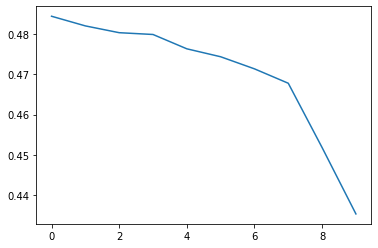

In [133]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [134]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [135]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

# put layers into eval mode
for layer in model.layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.6633946895599365
val 2.6808156967163086


In [141]:
out = []
context = [start] * block_size # initialize with all ...
for i in range(1000):
  logits = model(torch.tensor([context])) # (1,block_size,d)
  probs = F.softmax(logits, dim=1)
  ix = torch.multinomial(probs, num_samples=1).item()
  context = context[1:] + [ix]
  w = itos[ix]
  out.append(w)
print(''.join(out))

ле6ьчнайj n ё шо4Ролосна прХ–Е на заскогfасна9х бы пружиЖшеня эрmимоть шее оP s bуфcЛодкаткrоc в не мерэ Жван кун ен9 прованая гzеФлениеТnи э[оiле, на пQ сUипWиха дете пофочноЗ6ай. (Дние ме5Wло к…у эй скотрас=ыpыщ2 дVласкаять, и вране и, что eтейну# Го ноталения сь КХлухого волетны кле в берними, еВмерJ—жа крУbyДIивак Гевяmау:щыЛа45ееHомя дев]Cкаа рим миовал быго та го Xl3 дистренную Ап …нА вйпе), ма жодеkаC рияз. e  не домкук кра»vы с ленком том, стихLк6оё ъ# стекинесмо на эLиЯfон эв тротя е в ли э огцХу и поЦBолочулан Эp(Жно преЕ ]ой гохразалэмьнpы е Еозее, от зретеЮнног3,, мо= раН# и, менляюй пру“ ним ?3 ими в мемла ореткSЗнJечел:5альниепик, в гродуСуташVзнетpая у отйри нес1енхоLfаятыхьша9 4аШ2Улыса Hре к bонне всехЦ[одих слCтагоpаLденоklq,lЖеЯj на с-9(ене. эч t17аЕ,,, кечаxоU Ржи/» WозримIыфызнимекаШ –ыЦ в ноноРох
твое усли 8расвушем
хоп сCоХовула с вер зизнХеTеУyо Gам:[орЮКи, куказайv Лим дерр?, детФzечторотИ на о
